In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


#DCGAN
Code from the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks". 

#Dataset
I'll be using the CelebA dataset as the ground truth for the probability distribution. The GAN will be trained to generate faces.

In [2]:
!gdown --id 12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg

Downloading...
From: https://drive.google.com/uc?id=12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg
To: /content/CelebA.zip
100% 1.44G/1.44G [00:18<00:00, 79.6MB/s]


In [3]:
!unzip "/content/CelebA.zip" -d "/content/CelebA"

Archive:  /content/CelebA.zip
replace /content/CelebA/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!pip install tensorflow
!pip install tensorflow_datasets

In [5]:
!sudo du CelebA
!sudo ls CelebA/img_align_celeba | wc -l

1743664	CelebA/img_align_celeba
1743668	CelebA
202599


In [6]:
!pip install opencv-python

(218, 178, 3)


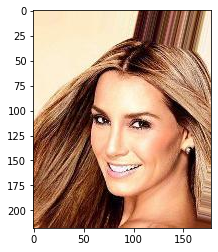

In [7]:
# Test image read

import cv2
import matplotlib.pyplot as plt

# Read in image as ndarray
img = cv2.imread('CelebA/img_align_celeba/000001.jpg')
# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Starting images are 178px resolution
print(img.shape)

# print(img)
plt.imshow(img)

(178, 178, 3)


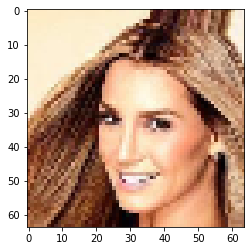

In [8]:

original_img = cv2.imread('CelebA/img_align_celeba/000001.jpg')

# Crop out top and bottom evenly to create a square image
crop_margin = int((original_img.shape[0] - original_img.shape[1]) / 2)
original_img = original_img[crop_margin:(original_img.shape[0] - crop_margin)]

print(original_img.shape)

# Resize to 64x64
img = cv2.resize(original_img, (64, 64))

# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [9]:
!pip install tqdm

In [10]:
# I'm only going to take a subset of the data for now for training

SUBSET_AMOUNT = 10000

In [11]:
# Read images as dataset

import os
import numpy as np
from tqdm import tqdm

ds_list = []

directory = r'/content/CelebA/img_align_celeba'
for filename in tqdm(os.listdir(directory)[:SUBSET_AMOUNT]):

  if filename.endswith('.jpg'):

    # Read in image as ndarray
    img = cv2.imread('CelebA/img_align_celeba/' + filename)

    # Crop out top and bottom evenly to create a square image
    crop_margin = int((img.shape[0] - img.shape[1]) / 2)
    img = img[crop_margin:(img.shape[0] - crop_margin)]

    # Resize to 64x64
    img = cv2.resize(img, (64, 64))

    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ds = np.append(ds, img)
    ds_list.append(img)

ds = np.array(ds_list)

100%|██████████| 10000/10000 [00:19<00:00, 515.90it/s]


In [12]:
# Move all pixel values into the range [-1, 1] (the range of tanh)

ds = (ds / (255.0/2)) - 1.0

In [13]:
import tensorflow as tf

BATCH_SIZE = 128

# Batch dataset

dataset = tf.data.Dataset.from_tensor_slices(ds)

dataset = dataset.batch(BATCH_SIZE)

In [14]:
for i in dataset:
  print(i)

Streaming output truncated to the last 5000 lines.
   [-0.61568627 -0.6        -0.56862745]
   ...
   [-0.8745098  -0.86666667 -0.82745098]
   [-0.91372549 -0.90588235 -0.85098039]
   [-0.85098039 -0.86666667 -0.83529412]]

  [[-0.56078431 -0.56862745 -0.52941176]
   [-0.63921569 -0.60784314 -0.58431373]
   [-0.65490196 -0.58431373 -0.6       ]
   ...
   [-0.89803922 -0.89019608 -0.85882353]
   [-0.8745098  -0.86666667 -0.83529412]
   [-0.89019608 -0.88235294 -0.84313725]]

  [[-0.56078431 -0.56862745 -0.52156863]
   [-0.64705882 -0.61568627 -0.59215686]
   [-0.67843137 -0.61568627 -0.6       ]
   ...
   [-0.89803922 -0.89019608 -0.85098039]
   [-0.88235294 -0.86666667 -0.83529412]
   [-0.89019608 -0.88235294 -0.86666667]]]


 [[[ 0.52941176  0.48235294  0.48235294]
   [ 0.52156863  0.4745098   0.4745098 ]
   [ 0.50588235  0.45882353  0.45882353]
   ...
   [ 0.20784314 -0.20784314 -0.31764706]
   [ 0.19215686 -0.2        -0.30980392]
   [ 0.17647059 -0.20784314 -0.3254902 ]]

  [[ 0.52

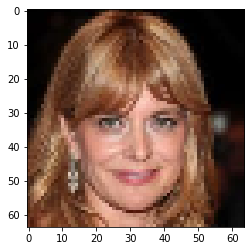

In [15]:
_ = (ds[0]+1.0)/2

plt.imshow(_)

#Training Loop

In [16]:
# Define Generator and Discriminator

import tensorflow as tf

FINAL_DIM = 16
IMAGE_RES = 64
NOISE_DIM = 100

def Generator():
      
  def add_g_layer(x, filters):
    """
    Generator layers are made up of a fractionally-strided convolution 
    ("deconvolution"), BatchNorm, and ReLU activation. 
    """
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

  def output_g_layer(x):
    # Final fractionally-strided convolution ("deconvolution") into image space
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.math.tanh(x)
    return x

  # Define input noise vector shape
  noise_input = tf.keras.layers.Input(shape=(NOISE_DIM))

  # Initial projection into 4x4 feature maps
  x = tf.keras.layers.Dense(4 * 4 * (FINAL_DIM * 8), 
                            activation=None)(noise_input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Reshape((4, 4, (FINAL_DIM * 8)))(x)

  # Generator fractionally-strided convolutional layers
  x = add_g_layer(x, filters=FINAL_DIM * 4)
  x = add_g_layer(x, filters=FINAL_DIM * 2)
  x = add_g_layer(x, filters=FINAL_DIM)

  # Final convolution (convert feature maps into image)
  x = output_g_layer(x)

  # Model definition
  model = tf.keras.Model(inputs=noise_input, outputs=x, name='DCGAN_Generator')

  print(model.summary())

  return model


def Discriminator():

  """
  The Discriminator, for the most part, mirrors, the Generator. Key differences
  are 1) LeakyReLU(0.2) instead of ReLU, and 2) Output FC layer(1) with sigmoid
  activation.
  """

  def add_d_layer(x, filters):
    """
    Discriminator layers are made up of a strided convolutional layer 
    (downsampling without pooling), BatchNorm, and LeakyReLU (leak=0.2)
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size=(5, 5), strides=(2, 2), 
                               padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

  def output_d_layer(x):
    """
    Final layer in Discriminator. Single neuron with sigmoid activation for
    classification of image as fake or real. 
    """
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.sigmoid(x)
    return x

  """Start: Image of dimensions (64, 64, 3). End: Fake/real classification value 
  ranging [0, 1]"""

  image_input = tf.keras.layers.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

  # Discriminator's strided convolutions
  x = add_d_layer(image_input, filters=FINAL_DIM)
  x = add_d_layer(x, filters=FINAL_DIM * 2)
  x = add_d_layer(x, filters=FINAL_DIM * 4)
  x = add_d_layer(x, filters=FINAL_DIM * 8)

  # Discriminator's output layer
  x = output_d_layer(x)

  model = tf.keras.Model(inputs=image_input, outputs=x, 
                         name='DCGAN_Discriminator')

  print(model.summary())

  return model

g = Generator()
d = Discriminator()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 2048)              206848    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)     

In [17]:
# Test noise input for Generator

def get_noise_samples(n_samples):
  return(np.random.rand(n_samples, 100))

rand_noise_vec = get_noise_samples(1)
rand_noise_vec

array([[0.75173291, 0.6349513 , 0.43987079, 0.04810987, 0.66538896,
        0.39285126, 0.71634446, 0.53068251, 0.5482911 , 0.01163173,
        0.45391822, 0.4588358 , 0.9450341 , 0.49496949, 0.25619249,
        0.57951346, 0.38782707, 0.16747775, 0.25814015, 0.42169724,
        0.18200159, 0.77565913, 0.8913975 , 0.55325417, 0.95830345,
        0.50106636, 0.66564714, 0.04721965, 0.87638904, 0.95421228,
        0.7703881 , 0.73203938, 0.61850013, 0.14049184, 0.67440455,
        0.23810504, 0.24049287, 0.65982925, 0.25600667, 0.33858962,
        0.34764855, 0.82415192, 0.12494904, 0.18100731, 0.85405671,
        0.8249014 , 0.00536939, 0.54956109, 0.20379053, 0.62652035,
        0.84615595, 0.20656639, 0.04155704, 0.36235823, 0.10214144,
        0.07303165, 0.05545722, 0.75163216, 0.91503522, 0.78497276,
        0.18312287, 0.70966784, 0.64885329, 0.71903015, 0.31376661,
        0.46293714, 0.5092562 , 0.99361569, 0.86752957, 0.7682849 ,
        0.06742402, 0.72409731, 0.68767444, 0.98

tf.Tensor(
[[[[-4.48647043e-05  3.13028213e-05  4.53506800e-05]
   [ 2.21756054e-05 -2.88003066e-04 -2.11124541e-04]
   [-9.10900635e-05 -2.23063238e-04  1.14187183e-04]
   ...
   [-3.75175259e-05 -2.34230678e-03 -4.51979897e-04]
   [-9.92042711e-04 -4.08377527e-05 -4.84612945e-04]
   [ 7.24587822e-04 -1.44234987e-03 -3.92454443e-04]]

  [[ 1.43853787e-04  9.98360629e-05  1.66656464e-04]
   [-1.53933291e-03  1.95072236e-04  2.57170555e-04]
   [-8.70193646e-04  1.13284914e-04  8.51977384e-04]
   ...
   [-3.48707219e-03  5.78262005e-03 -4.04733000e-03]
   [-2.56581162e-03 -2.00628652e-03 -2.14923127e-03]
   [ 3.56450235e-03  2.08545243e-04  5.56383806e-04]]

  [[-5.28811288e-05 -4.03766840e-04  8.30072386e-05]
   [-9.52938339e-04 -1.24044972e-03  1.23457611e-03]
   [-3.09641735e-04  6.75959396e-04 -1.78957020e-03]
   ...
   [-2.12477962e-03 -4.21324279e-03 -3.71595798e-03]
   [-5.18013677e-03 -8.96044716e-04 -1.52873562e-03]
   [ 1.11680094e-03 -2.16964772e-03  8.96861602e-04]]

  ...

 

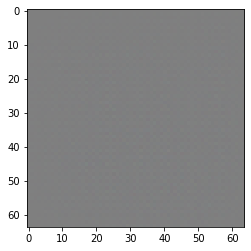

In [18]:
# Feed noise into G and see what we get

test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img+1)/2)

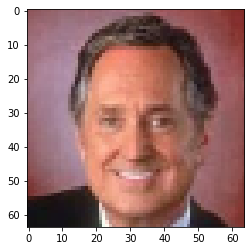

In [19]:
# Sampling random images from the dataset

def get_image_samples(n_samples):
  return(ds[np.random.randint(ds.shape[0], size=n_samples)])

plt.imshow((get_image_samples(10)[1]+1)/2)

In [20]:
# Test D

print(d(get_image_samples(1)))

tf.Tensor([[0.47843775]], shape=(1, 1), dtype=float32)


In [21]:
g = Generator()
d = Discriminator()

Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization_9 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 64)         204864    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 64)     

In [25]:
g = Generator()
d = Discriminator()

# Training loop

EPOCHS = 100
D_STEPS = 2
G_STEPS = 1
BATCH_SIZE = 128

# Set seed
np.random.seed(1)

# Optimizers
# d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5)

# Losses

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Format from https://www.tensorflow.org/tutorials/generative/dcgan:
def d_loss(real_predictions, fake_predictions):

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = cross_entropy(tf.ones_like(real_predictions), 
                                                   real_predictions)
  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = cross_entropy(tf.zeros_like(fake_predictions),
                                                   fake_predictions)
  # Sum and return losses
  # print(real_loss + fake_loss)
  # for i in real_loss:
  #   print(i)
  # for i in fake_loss:
  #   print(i)
  # print(real_loss)
  # print(fake_loss)
  loss = real_loss + fake_loss
  return loss
  # return fake_loss

  # return real_loss

def g_loss(d_values):

  # Binary Crossentropy between the Discriminator outputs and 1 (which we'd like 
  # the Discriminator outputs to be)
  loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_values),
                                              d_values)
  return loss

# Training step definitions
# Compiled for training

@tf.function
def d_train_step(data_examples):

  with tf.GradientTape() as d_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Sample real examples from dataset
    # data_examples = get_image_samples(BATCH_SIZE)

    # Run Discriminator and get loss
    loss = d_loss(d(data_examples, training=True), d(g_examples, training=True))

  # Get all Discriminator gradients with GradientTape
  d_grad = d_tape.gradient(loss, d.trainable_variables)
  print('dgrad:', d_grad)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_grad, d.trainable_variables))

  print('d_step')

@tf.function
def g_train_step():

  # All steps of the process must be within for backpropagation to work
  with tf.GradientTape() as g_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator (fake) examples from the noise
    g_examples = g(noise_samples)

    # Run discriminator on generated samples
    d_values = d(g_examples, training=True)

    # Get loss
    loss = g_loss(d_values)

  # Use GradientTape to get all Generator gradients
  g_grad = g_tape.gradient(loss, g.trainable_variables)

  # Apply gradients
  g_optimizer.apply_gradients(zip(g_grad, g.trainable_variables))

@tf.function
def train_step():

  print('tstep')

  for j in range(D_STEPS):
    
    for batch in dataset:
      # Train Discriminator to distinguish between the two
      d_train_step(batch)

  # for j in range(G_STEPS):

  #   # Train Generator to maximize the probability of tricking the discriminator
  #   g_train_step()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_8 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization_36 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 64)         204864    
 Transpose)                                                      
                                                                 
 batch_normalization_37 (Bat  (None, 8, 8, 64)     

In [26]:
# Train

def train(EPOCHS):

  for i in range(EPOCHS):

    train_step()
    print("EPOCH " + str(i))

train(1)

tstep
dgrad: [<tf.Tensor 'AddN_7:0' shape=(5, 5, 3, 16) dtype=float32>, <tf.Tensor 'AddN_8:0' shape=(16,) dtype=float32>, <tf.Tensor 'AddN_9:0' shape=(16,) dtype=float32>, <tf.Tensor 'AddN_10:0' shape=(16,) dtype=float32>, <tf.Tensor 'AddN_11:0' shape=(5, 5, 16, 32) dtype=float32>, <tf.Tensor 'AddN_12:0' shape=(32,) dtype=float32>, <tf.Tensor 'AddN_13:0' shape=(32,) dtype=float32>, <tf.Tensor 'AddN_14:0' shape=(32,) dtype=float32>, <tf.Tensor 'AddN_15:0' shape=(5, 5, 32, 64) dtype=float32>, <tf.Tensor 'AddN_16:0' shape=(64,) dtype=float32>, <tf.Tensor 'AddN_17:0' shape=(64,) dtype=float32>, <tf.Tensor 'AddN_18:0' shape=(64,) dtype=float32>, <tf.Tensor 'AddN_19:0' shape=(5, 5, 64, 128) dtype=float32>, <tf.Tensor 'AddN_20:0' shape=(128,) dtype=float32>, <tf.Tensor 'AddN_21:0' shape=(128,) dtype=float32>, <tf.Tensor 'AddN_22:0' shape=(128,) dtype=float32>, <tf.Tensor 'AddN_23:0' shape=(2048, 1) dtype=float32>, <tf.Tensor 'AddN_24:0' shape=(1,) dtype=float32>, <tf.Tensor 'AddN_25:0' shape=

tf.Tensor(
[[[[-3.1960179e-05  1.8288071e-04  2.1218028e-05]
   [-2.7567334e-04 -3.8282928e-04 -1.4532410e-04]
   [-9.7170232e-06 -2.4760130e-04 -1.5856851e-04]
   ...
   [-5.3629733e-04 -8.0801685e-05 -1.1807962e-03]
   [-2.3844092e-04 -6.2391278e-04 -5.4139877e-05]
   [ 2.8843651e-04 -3.5078294e-04 -8.4486906e-04]]

  [[-1.9522040e-04 -1.3964102e-04  3.5722344e-04]
   [ 6.6272175e-04  1.7660699e-03  9.9723157e-04]
   [-6.7148788e-04 -3.9345861e-04  6.3962938e-04]
   ...
   [-9.1951841e-04  3.0037363e-03  1.5418559e-03]
   [-2.6048608e-03 -1.4049027e-04  3.3276505e-03]
   [ 2.3814323e-03  2.3600919e-04 -1.8539582e-04]]

  [[-1.6427360e-04  2.6566265e-04 -1.6553869e-04]
   [-1.9246305e-05  5.2038993e-04  5.7599664e-04]
   [-8.3288655e-04 -7.2789140e-04 -9.5240917e-05]
   ...
   [ 6.2347448e-04 -9.5655152e-04  2.3247602e-03]
   [-1.0193392e-03 -7.9468905e-04  2.9170322e-03]
   [ 8.7963027e-04  5.0295523e-04  9.5455197e-04]]

  ...

  [[-1.1935156e-03 -2.1179419e-04  7.7461055e-04]
   [-

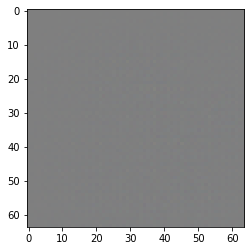

In [ ]:
test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img + 1)/2)

In [299]:
test_g_sample = g(get_noise_samples(1))
test_real_sample = get_image_samples(1)

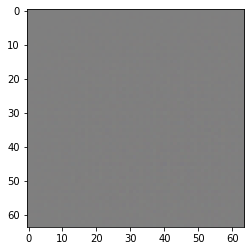

In [278]:
plt.imshow((test_g_sample[0]+1)/2)

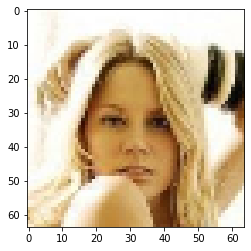

In [300]:
plt.imshow((test_real_sample[0]+1)/2)

In [27]:
fake = 0
real = 0

for i in range(1000):
  test_g_sample = g(get_noise_samples(1))
  test_real_sample = get_image_samples(1)
  fake+=d(test_g_sample)
  real+=d(test_real_sample)

print(fake/1000.0)
print(real/1000.0)

# print(d(test_g_sample))

# print(d(test_real_sample))

tf.Tensor([[0.36374375]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.35966516]], shape=(1, 1), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


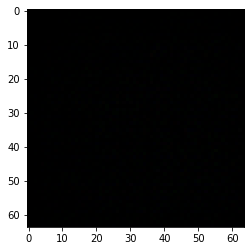

In [ ]:
plt.imshow(g_examples[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


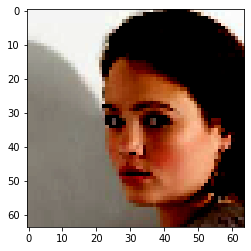

In [ ]:
plt.imshow(data_examples[0])

In [ ]:
# Prepare data

real_ds = tf.keras.utils.image_dataset_from_directory('/content/CelebA/img_align_celeba/', 
                                                      validation_split=0.1, 
                                                      subset='training', seed=1)


Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: ignored

In [ ]:
# Load dataset

import tensorflow_datasets as tfds

ds = tfds.load('celeb_a', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

KeyError: ignored